In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import time
import itertools
import tensorflow as tf
import keras.backend as K
from keras import Sequential
from keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings("ignore")


In [442]:
# reading data movielens 100k
data = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp'])
item_details = pd.read_csv('ml-100k/u.item', sep='|', names=['itemId', 'itemName'],usecols=range(2), encoding='latin-1')
data.merge(item_details,on='itemId', how='left')

,userId,itemId,rating,timestamp,itemName
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)


In [443]:
len(data['userId'].unique())

943

In [444]:
print(data.groupby('userId').itemId.nunique())
print(data.groupby('userId').itemId.nunique().min())#min 20
print(data.groupby('userId').itemId.nunique().max())#max 737

userId
1      272
2       62
3       54
4       24
5      175
      ... 
939     49
940    107
941     22
942     79
943    168
Name: itemId, Length: 943, dtype: int64
20
737


In [445]:
def sortItemsByTime(data):
    sorted_users = []
    for i, u in enumerate(data['userId'].unique()):
        temp = data[data['userId'] == u]
        temp = temp.sort_values('timestamp').reset_index()
        temp.drop('index', axis=1, inplace=True)
        sorted_users.append(temp)
    return sorted_users
    

In [446]:
indexlist=[]
for i, u in enumerate(data['userId'].unique()):
    #print('i',i)
    #print('index',data['userId'].index)
    temp = data[data['userId'] == u]
    #print('inex',temp.index)
    temp = temp.sort_values('rating',ascending=False)
    #print('inedsfsdfsdx',temp.index[0])
    indexlist.append(temp.index[0])
    indexlist.append(temp.index[1])
    indexlist.append(temp.index[2])
    indexlist.append(temp.index[3])
                    
data = data.drop(indexlist)
data.reset_index()           
         

,index,userId,itemId,rating,timestamp
0,0,196,242,3,881250949
1,1,186,302,3,891717742
2,2,22,377,1,878887116
3,3,244,51,2,880606923
4,4,166,346,1,886397596
...,...,...,...,...,...
96223,99995,880,476,3,880175444
96224,99996,716,204,5,879795543
96225,99997,276,1090,1,874795795
96226,99998,13,225,2,882399156


In [447]:
with open('testdata.csv', mode='w') as file:
        f_writer = csv.writer(file, delimiter=';')
        f_writer.writerow(['userId', 'state'])
        
        for i, u in enumerate(data['userId'].unique()):
            temp = data[data['userId'] == u]
            temp = temp.sort_values('rating',ascending=False)
            temp1=temp
            temp1=temp1[0:4].reset_index()
            temp1.drop('index', axis=1, inplace=True)
            str_last=''
            for j in range(4):
                state_str=str(temp1['itemId'][j]) + '&' 
                rate_str=str(temp1['rating'][j]) +'|'
                str_last +=  state_str  + rate_str 

            f_writer.writerow([u, str_last])     
                                          

In [448]:
class MovieData():
     def __init__(self,data):
            self.data  = data
            self.users = data['userId'].unique()
            self.items = data['itemId'].unique()
            self.histo = sortItemsByTime(data)
            self.train = []
            self.test  = []
            
     def divideTrainAndTestSet(self):
        random.Random(42).shuffle(self.histo)
        self.train = self.histo[:int((0.8 * len(self.histo)))]
        self.test  = self.histo[int((0.8 * len(self.histo))):]
        self.user_train = [h.iloc[0,0] for h in self.train]
        self.user_test  = [h.iloc[0,0] for h in self.test] 
      
        
     def sample_histo(self, user_histo, action_ratio=0.8, max_samp_by_user=5,  max_state=100, max_action=50, nb_states=[], nb_actions=[]):
        n = len(user_histo)
        sep = int(action_ratio * n)
        nb_sample = random.randint(1, max_samp_by_user)
        if not nb_states:
            nb_states = [min(random.randint(1, sep), max_state) for i in range(nb_sample)]
        if not nb_actions:
            nb_actions = [min(random.randint(1, n - sep), max_action) for i in range(nb_sample)]
        assert len(nb_states) == len(nb_actions), 'Given array must have the same size'
        states  = []
        actions = []
        # random bir şekilde state ve actionlar oluşturuluyor.
        for i in range(len(nb_states)):
            sample_states = user_histo.iloc[0:sep].sample(nb_states[i]) #kişinin izledigi filmlerin yüzde 80 i states % 20 si action olarak
            sample_actions = user_histo.iloc[-(n - sep):].sample(nb_actions[i])
            sample_state = []
            sample_action = []
            for j in range(nb_states[i]):
                row   = sample_states.iloc[j]
                state = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
                sample_state.append(state)
            for j in range(nb_actions[i]):
                row    = sample_actions.iloc[j]
                action = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
                sample_action.append(action)
            states.append(sample_state)
            actions.append(sample_action)
        return states, actions  
         
     def write_csv(self, filename, histo_to_write):
        history_length = 12
        ra_length = 4 
        delimiter=';'
        action_ratio = 0.8
        max_samp_by_user = 5
        max_state = 100
        max_action = 50
        nb_states = [history_length]
        nb_actions = [ra_length]
    
        with open(filename, mode='w') as file:
          f_writer = csv.writer(file, delimiter=delimiter)
          f_writer.writerow(['state', 'action_reward', 'n_state'])
          for user_histo in histo_to_write:
            states, actions = self.sample_histo(user_histo, action_ratio, max_samp_by_user, max_state, max_action, nb_states, nb_actions)
            for i in range(len(states)):
              state_str   = '|'.join(states[i])
              action_str  = '|'.join(actions[i])
              n_state_str = state_str + '|' + action_str
              f_writer.writerow([state_str, action_str, n_state_str])

In [449]:
def readFile(filePath):
    data = pd.read_csv(filePath, sep=';')
    for col in ['state', 'n_state', 'action_reward']:
        data[col] = [np.array([[np.int(k) for k in ee.split('&')] for ee in e.split('|')]) for e in data[col]]
    for col in ['state', 'n_state']:
        data[col] = [np.array([e[0] for e in l]) for l in data[col]]
    data['action'] = [[e[0] for e in l] for l in data['action_reward']]
    data['reward'] = [tuple(e[1] for e in l) for l in data['action_reward']]
    data.drop(columns=['action_reward'], inplace=True)
    return data        

In [450]:
class Actor():
    def __init__(self, sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embedding_size, tau, learning_rate, scope='actor'):
        self.sess = sess
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.batch_size = batch_size
        self.ra_length = ra_length
        self.history_length = history_length
        self.embedding_size = embedding_size
        self.tau = tau
        self.learning_rate = learning_rate
        self.scope = scope
        with tf.variable_scope(self.scope):
            self.action_weights, self.state, self.sequence_length = self._build_net('estimator_actor')
            self.network_params = tf.trainable_variables()
            self.target_action_weights, self.target_state, self.target_sequence_length = self._build_net('target_actor')
            self.target_network_params = tf.trainable_variables()[len(self.network_params):] 
            self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
                                               for i in range(len(self.target_network_params))]
            self.update_target_network_params = [self.target_network_params[i].assign(
            tf.multiply(self.tau, self.network_params[i]) +
            tf.multiply(1 - self.tau, self.target_network_params[i]))
            for i in range(len(self.target_network_params))]
            self.action_gradients = tf.placeholder(tf.float32, [None, self.action_space_size])
            gradients = tf.gradients(tf.reshape(self.action_weights, [self.batch_size, self.action_space_size], name='42222222222'),
                               self.network_params,
                               self.action_gradients)
            params_gradients = list(map(lambda x: tf.div(x, self.batch_size * self.action_space_size), gradients))
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(
              zip(params_gradients, self.network_params))
    
    def _build_net(self, scope):
        def gather_last_output(data, seq_lens):
            def cli_value(x, v):
                y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
                x = tf.cast(x, tf.int64)
                return tf.where(tf.greater(x, y), x, y)
            batch_range = tf.range(tf.cast(tf.shape(data)[0], dtype=tf.int64), dtype=tf.int64)
            tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
            indices = tf.stack([batch_range, tmp_end], axis=1)
            return tf.gather_nd(data, indices)
        with tf.variable_scope(scope):
            state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
            state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
            sequence_length = tf.placeholder(tf.int32, [None], 'sequence_length')
            cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
            outputs, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
            last_output = gather_last_output(outputs, sequence_length)
            x = tf.keras.layers.Dense(self.ra_length * self.embedding_size)(last_output)
            action_weights = tf.reshape(x, [-1, self.ra_length, self.embedding_size])
        return action_weights, state, sequence_length
    def train(self, state, sequence_length, action_gradients):
        self.sess.run(self.optimizer,
                  feed_dict={
                      self.state: state,
                      self.sequence_length: sequence_length,
                      self.action_gradients: action_gradients})
    def predict(self, state, sequence_length):
        #state length 1200
        return self.sess.run(self.action_weights,
                         feed_dict={
                             self.state: state,
                             self.sequence_length: sequence_length})
    def predict_target(self, state, sequence_length):
        return self.sess.run(self.target_action_weights,
                         feed_dict={
                             self.target_state: state,
                             self.target_sequence_length: sequence_length})
    def init_target_network(self):
        self.sess.run(self.init_target_network_params)
    def update_target_network(self):
        self.sess.run(self.update_target_network_params)
    def get_recommendation_list(self, ra_length, noisy_state, embeddings, target=False):
        def get_score(weights, embedding, batch_size):
            ret = np.dot(weights, embedding.T)
            return ret
        batch_size = noisy_state.shape[0]#batch_size 1
        
        method = self.predict_target if target else self.predict
        weights = method(noisy_state, [ra_length] * batch_size)
        scores = np.array([[[get_score(weights[i][k], embedding, batch_size)
                             for embedding in embeddings.get_embedding_vector()]
                             for k in range(ra_length)]
                             for i in range(batch_size)])
       
        return np.array([[embeddings.get_embedding(np.argmax(scores[i][k]))
                          for k in range(ra_length)]
                          for i in range(batch_size)])
                             
    

In [346]:
sorted_users=sortItemsByTime(data)

In [451]:
class Critic():
    def __init__(self, sess, state_space_size, action_space_size, history_length, embedding_size, tau, learning_rate, scope='critic'):
        self.sess = sess
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.history_length = history_length
        self.embedding_size = embedding_size
        self.tau = tau
        self.learning_rate = learning_rate
        self.scope = scope
        with tf.variable_scope(self.scope):
            self.critic_Q_value, self.state, self.action, self.sequence_length = self._build_net('estimator_critic')
            self.network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='estimator_critic')
            self.target_Q_value, self.target_state, self.target_action, self.target_sequence_length = self._build_net('target_critic')
            self.target_network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_critic')
            self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
                                               for i in range(len(self.target_network_params))]
            self.update_target_network_params = [self.target_network_params[i].assign(
                tf.multiply(self.tau, self.network_params[i]) +
                tf.multiply(1 - self.tau, self.target_network_params[i]))
                for i in range(len(self.target_network_params))]
            self.expected_reward = tf.placeholder(tf.float32, [None, 1])
            self.loss = tf.reduce_mean(tf.squared_difference(self.expected_reward, self.critic_Q_value))
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
            self.action_gradients = tf.gradients(self.critic_Q_value, self.action)
    def _build_net(self, scope):
        def gather_last_output(data, seq_lens):
            def cli_value(x, v):
                y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
                return tf.where(tf.greater(x, y), x, y)
            this_range = tf.range(tf.cast(tf.shape(seq_lens)[0], dtype=tf.int64), dtype=tf.int64)
            tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
            indices = tf.stack([this_range, tmp_end], axis=1)
            return tf.gather_nd(data, indices)
        with tf.variable_scope(scope):
            state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
            state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
            action = tf.placeholder(tf.float32, [None, self.action_space_size], 'action')
            sequence_length = tf.placeholder(tf.int64, [None], name='critic_sequence_length')
            cell = tf.nn.rnn_cell.GRUCell(self.history_length,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
            predicted_state, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
            predicted_state = gather_last_output(predicted_state, sequence_length)
            inputs = tf.concat([predicted_state, action], axis=-1)
            layer1 = tf.layers.Dense(32, activation=tf.nn.relu)(inputs)
            layer2 = tf.layers.Dense(16, activation=tf.nn.relu)(layer1)
            critic_Q_value = tf.layers.Dense(1)(layer2)
            return critic_Q_value, state, action, sequence_length
        
    def train(self, state, action, sequence_length, expected_reward):
        return self.sess.run([self.critic_Q_value, self.loss, self.optimizer],
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length,
                             self.expected_reward: expected_reward})
    def predict(self, state, action, sequence_length):
        return self.sess.run(self.critic_Q_value,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})
    def predict_target(self, state, action, sequence_length):
        return self.sess.run(self.target_Q_value,
                         feed_dict={
                             self.target_state: state,
                             self.target_action: action,
                             self.target_sequence_length: sequence_length})
    def get_action_gradients(self, state, action, sequence_length):
        return np.array(self.sess.run(self.action_gradients,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})[0])
    def init_target_network(self):
        self.sess.run(self.init_target_network_params)
    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

In [452]:
class Embeddings:
    def __init__(self, item_embeddings):
        self.item_embeddings = item_embeddings
    def size(self):    
        return self.item_embeddings.shape[1]
    def get_embedding_vector(self):
        return self.item_embeddings
    def get_embedding(self, item_index):
        return self.item_embeddings[item_index]
    def embed(self, item_list):
        return np.array([self.get_embedding(item) for item in item_list])

In [453]:
def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [454]:
class EmbeddingsInformation:
  def  __init__(self, train_users, data):
    self.train_users = train_users

    #preprocess
    self.data = data.sort_values(by=['timestamp'])
    self.data['userId'] = self.data['userId'] - 1
    self.data['itemId'] = self.data['itemId'] - 1
    self.user_count = self.data['userId'].max() + 1
    self.movie_count = self.data['itemId'].max() + 1
    self.user_movies = {} #list of rated movies by each user
    for userId in range(self.user_count):
        self.user_movies[userId] = self.data[self.data.userId == userId]['itemId'].tolist()
    self.m = self.model()

  def model(self, hidden_layer_size=100):
    m = Sequential()
    m.add(Dense(hidden_layer_size, input_shape=(1, self.movie_count)))
    m.add(Dropout(0.2))
    m.add(Dense(self.movie_count, activation='softmax'))
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m
  
  def generate_input(self, user_id):
    user_movies_count = len(self.user_movies[user_id])
    #picking random movie
    random_index = np.random.randint(0, user_movies_count-1) # -1 avoids taking the last movie
    #generate 1 row each user's movie_count times column with zero initialize
    target = np.zeros((1, self.movie_count))
    #set 1 randomly chosen item id.
    target[0][self.user_movies[user_id][random_index]] = 1
    #setting context
    #generate context 1 row ,user's movie_count times column
    context = np.zeros((1, self.movie_count))
    # randomly chosen item id's front + item id's after element list len
    context[0][self.user_movies[user_id][:random_index] + self.user_movies[user_id][random_index+1:]] = 1
    return context, target

  def train(self, nb_epochs = 300, batch_size = 10000):      
    '''
    Trains the model from train_users's history information
    '''
    for i in range(nb_epochs):
        print('%d/%d' % (i+1, nb_epochs))
        batch = [self.generate_input(user_id=np.random.choice(self.train_users) - 1) for _ in range(batch_size)]
        X_train = np.array([b[0] for b in batch])
        y_train = np.array([b[1] for b in batch])
        self.m.fit(X_train, y_train, epochs=1, validation_split=0.5)
        
  def test(self, test_users, batch_size = 100000):
    '''
    Returns [loss, accuracy] on the test set
    '''
    batch_test = [self.generate_input(user_id=np.random.choice(test_users) - 1) for _ in range(batch_size)]
    X_test = np.array([b[0] for b in batch_test])
    y_test = np.array([b[1] for b in batch_test])
    return self.m.evaluate(X_test, y_test)

  def save_embeddings(self, file_name):
    '''
    Generates a csv file containg the vector embedding for each movie.
    https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
    '''
    inp = self.m.input                                          
    outputs = [layer.output for layer in self.m.layers]          
    functor = K.function([inp, K.learning_phase()], outputs )   

    #append embeddings to vectors
    vectors = []
    for movie_id in range(self.movie_count):
      movie = np.zeros((1, 1, self.movie_count))
      movie[0][0][movie_id] = 1
      layer_outs = functor([movie])
      vector = [str(v) for v in layer_outs[0][0][0]]
      vector = '|'.join(vector)
      vectors.append([movie_id, vector])

    #saves as a csv file
    embeddings = pd.DataFrame(vectors, columns=['item_id', 'vectors']).astype({'item_id': 'int32'})
    embeddings.to_csv(file_name, sep=';', index=False)

In [455]:
# Hyperparameters
history_length = 12 # kullanılan state sayısı
ra_length = 4 # önerilen film listesi büyüklügü
discount_factor = 0.99 # Gamma degeri  1 e yakın bir deger secilir
actor_lr = 0.0001
critic_lr = 0.001
tau = 0.001 
batch_size = 64
nb_episodes = 100
nb_rounds = 50
filename_summary = 'summary.txt'
alpha = 0.5
gamma = 0.9 
buffer_size = 1000000
fixed_length = True
movieData=MovieData(data)
movieData.divideTrainAndTestSet()
movieData.write_csv('train.csv', movieData.train)
movieData.write_csv('test.csv', movieData.test)
data = readFile('train.csv')


In [ ]:
eg = EmbeddingsInformation(movieData.user_train, pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp']))
eg.train(nb_epochs=300)
train_loss, train_accuracy = eg.test(movieData.user_train)
print('Train set: Loss=%.4f ; Accuracy=%.4f%%' % (train_loss, train_accuracy * 100))
test_loss, test_accuracy = eg.test(movieData.user_test)
print('Test set: Loss=%.4f ; Accuracy=%.1f%%' % (test_loss, test_accuracy * 100))
eg.save_embeddings('embeddings.csv')

In [379]:
embeddings = Embeddings(np.array([[np.float64(k) for k in e.split('|')]
                   for e in  pd.read_csv('embeddings.csv', sep=';')['vectors']]))

state_space_size = embeddings.size() * history_length
print('state_space_size:',state_space_size)
action_space_size = embeddings.size() * ra_length
print('action_space_size',action_space_size)

state_space_size: 1200
action_space_size 400


In [456]:
class Environment():
    def __init__(self, data, embeddings, alpha, gamma, fixed_length):
        self.embeddings = embeddings
        self.embedded_data = pd.DataFrame()
        self.embedded_data['state'] = [np.array([embeddings.get_embedding(item_id)
                                                 for item_id in row['state']]) for _, row in data.iterrows()]
        self.embedded_data['action'] = [np.array([embeddings.get_embedding(item_id)
                                                  for item_id in row['action']]) for _, row in data.iterrows()]
        self.embedded_data['reward'] = data['reward']
        self.alpha = alpha 
        self.gamma = gamma 
        self.fixed_length = fixed_length
        self.current_state = self.reset()
        self.groups = self.get_groups()
    def reset(self):
        self.init_state = self.embedded_data['state'].sample(1).values[0]
        return self.init_state
    def step(self, actions):
        simulated_rewards, cumulated_reward = self.simulate_rewards(self.current_state.reshape((1, -1)), actions.reshape((1, -1)))
        for k in range(len(simulated_rewards)):
            if simulated_rewards[k] > 0:
                self.current_state = np.append(self.current_state, [actions[k]], axis=0)
                if self.fixed_length:
                    self.current_state = np.delete(self.current_state, 0, axis=0)
        return cumulated_reward, self.current_state
    def get_groups(self):
        groups = []
        for rewards, group in self.embedded_data.groupby(['reward']):
            size = group.shape[0]
            states = np.array(list(group['state'].values))
            actions = np.array(list(group['action'].values))
            groups.append({
            'size': size, 
            'rewards': rewards, 
            'average state': (np.sum(states / np.linalg.norm(states, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)), # s_x^-
            'average action': (np.sum(actions / np.linalg.norm(actions, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)) # a_x^-
            })
        return groups
    def simulate_rewards(self, current_state, chosen_actions, reward_type='grouped cosine'):
        def cosine_state_action(s_t, a_t, s_i, a_i):
            cosine_state = np.dot(s_t, s_i.T) / (np.linalg.norm(s_t, 2) * np.linalg.norm(s_i, 2))
            cosine_action = np.dot(a_t, a_i.T) / (np.linalg.norm(a_t, 2) * np.linalg.norm(a_i, 2))
            return (self.alpha * cosine_state + (1 - self.alpha) * cosine_action).reshape((1,))
        if reward_type == 'normal':
            probabilities = [cosine_state_action(current_state, chosen_actions, row['state'], row['action'])
                             for _, row in self.embedded_data.iterrows()]
        elif reward_type == 'grouped average':
            probabilities = np.array([g['size'] for g in self.groups]) *\
            [(self.alpha * (np.dot(current_state, g['average state'].T) / np.linalg.norm(current_state, 2))\
              + (1 - self.alpha) * (np.dot(chosen_actions, g['average action'].T) / np.linalg.norm(chosen_actions, 2)))
             for g in self.groups]
        elif reward_type == 'grouped cosine':
            probabilities = [cosine_state_action(current_state, chosen_actions, g['average state'], g['average action'])
                             for g in self.groups]
        probabilities = np.array(probabilities) / sum(probabilities)
        if reward_type == 'normal':
            returned_rewards = self.embedded_data.iloc[np.argmax(probabilities)]['reward']
        elif reward_type in ['grouped average', 'grouped cosine']:
            returned_rewards = self.groups[np.argmax(probabilities)]['rewards']
        def overall_reward(rewards, gamma):
            return np.sum([gamma**k * reward for k, reward in enumerate(rewards)])
        if reward_type in ['normal', 'grouped average']:
            cumulated_reward = overall_reward(returned_rewards, self.gamma)
        elif reward_type == 'grouped cosine':
            cumulated_reward = np.sum([p * overall_reward(g['rewards'], self.gamma)
                                       for p, g in zip(probabilities, self.groups)])
        return returned_rewards, cumulated_reward

In [457]:
class ReplayMemory():
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []
    def add(self, state, action, reward, n_state):
        self.buffer.append([state, action, reward, n_state])
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)
    def size(self):
        return len(self.buffer)
    def sample_batch(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [458]:
def experience_replay(replay_memory, batch_size, actor, critic, embeddings, ra_length, state_space_size, action_space_size, discount_factor):
    samples = replay_memory.sample_batch(batch_size)
    states = np.array([s[0] for s in samples])
    actions = np.array([s[1] for s in samples])
    rewards = np.array([s[2] for s in samples])
    n_states = np.array([s[3] for s in samples]).reshape(-1, state_space_size)
    n_actions = actor.get_recommendation_list(ra_length, states, embeddings, target=True).reshape(-1, action_space_size)
    target_Q_value = critic.predict_target(n_states, n_actions, [ra_length] * batch_size)
    expected_rewards = rewards + discount_factor * target_Q_value
    critic_Q_value, critic_loss, _ = critic.train(states, actions, [ra_length] * batch_size, expected_rewards)
    action_gradients = critic.get_action_gradients(states, n_actions, [ra_length] * batch_size)
    actor.train(states, [ra_length] * batch_size, action_gradients)
    critic.update_target_network()
    actor.update_target_network()
    return np.amax(critic_Q_value), critic_loss

In [459]:
class OrnsteinUhlenbeckNoise:
  
  def __init__(self, action_space_size, mu=0, theta=0.5, sigma=0.2):
    self.action_space_size = action_space_size
    self.mu = mu
    self.theta = theta
    self.sigma = sigma
    self.state = np.ones(self.action_space_size) * self.mu

  def get(self):
    self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.rand(self.action_space_size)
    return self.state

def train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary):


  # Set up summary operators
  def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar('reward', episode_reward)
    episode_max_Q = tf.Variable(0.)
    tf.summary.scalar('max_Q_value', episode_max_Q)
    critic_loss = tf.Variable(0.)
    tf.summary.scalar('critic_loss', critic_loss)

    summary_vars = [episode_reward, episode_max_Q, critic_loss]
    summary_ops = tf.summary.merge_all()
    return summary_ops, summary_vars

  summary_ops, summary_vars = build_summaries()
  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter(filename_summary, sess.graph)

  # Initialize target network f′ and Q′'
  actor.init_target_network()
  critic.init_target_network()
  replay_memory = ReplayMemory(buffer_size) 
  replay = False

  start_time = time.time()
  for i_session in range(nb_episodes): 
    session_reward = 0
    session_Q_value = 0
    session_critic_loss = 0

    states = environment.reset() # 'Initialize state s_0 from previous sessions'
    
    if (i_session + 1) % 10 == 0: # Update average parameters every 10 episodes
      environment.groups = environment.get_groups()
      
    exploration_noise = OrnsteinUhlenbeckNoise(history_length * embeddings.size())

    for t in range(nb_rounds): #for t = 1, T do
     
      # 'Select an action a_t = {a_t^1, ..., a_t^K} according to Algorithm 2'
      actions = actor.get_recommendation_list(
          ra_length,
          states.reshape(1, -1), # TODO + exploration_noise.get().reshape(1, -1),
          embeddings).reshape(ra_length, embeddings.size())

      #  Execute action a_t and observe the reward list {r_t^1, ..., r_t^K} for each item in a_t'
      rewards, next_states = environment.step(actions)

      # 'Store transition (s_t, a_t, r_t, s_t+1)'
      replay_memory.add(states.reshape(history_length * embeddings.size()),
                        actions.reshape(ra_length * embeddings.size()),
                        [rewards],
                        next_states.reshape(history_length * embeddings.size()))

      states = next_states # 'Set s_t = s_t+1'

      session_reward += rewards
      
      
      if replay_memory.size() >= batch_size: # Experience replay
        replay = True
        replay_Q_value, critic_loss = experience_replay(replay_memory, batch_size,
          actor, critic, embeddings, ra_length, history_length * embeddings.size(),
          ra_length * embeddings.size(), discount_factor)
        session_Q_value += replay_Q_value
        session_critic_loss += critic_loss

      summary_str = sess.run(summary_ops,
                             feed_dict={summary_vars[0]: session_reward,
                                        summary_vars[1]: session_Q_value,
                                        summary_vars[2]: session_critic_loss})
      
      writer.add_summary(summary_str, i_session)

   
    str_loss = str('Loss=%0.4f' % session_critic_loss)
    print(('Episode %d/%d Reward=%d Time=%ds ' + (str_loss if replay else 'No replay')) % (i_session + 1, nb_episodes, session_reward, time.time() - start_time))
    start_time = time.time()

  writer.close()
  tf.train.Saver().save(sess, 'models.h5', write_meta_graph=False)

In [380]:
environment = Environment(data, embeddings, alpha, gamma, fixed_length)
tf.reset_default_graph()
sess = tf.Session()
embedded_data = pd.DataFrame()
embedded_data['state'] = [np.array([embeddings.get_embedding(1) for item_id in row['state']]) for _, row in data.iterrows()]

In [381]:
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)
train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)


Episode 1/100 Reward=539 Time=6s No replay
Episode 2/100 Reward=539 Time=50s Loss=1507.8911
Episode 3/100 Reward=539 Time=67s Loss=125.4557
Episode 4/100 Reward=539 Time=64s Loss=75.6369
Episode 5/100 Reward=539 Time=67s Loss=53.2248
Episode 6/100 Reward=539 Time=69s Loss=52.1822
Episode 7/100 Reward=539 Time=70s Loss=40.5407
Episode 8/100 Reward=539 Time=66s Loss=29.1090
Episode 9/100 Reward=539 Time=66s Loss=22.6005
Episode 10/100 Reward=539 Time=70s Loss=17.0641
Episode 11/100 Reward=539 Time=67s Loss=14.7949
Episode 12/100 Reward=539 Time=68s Loss=12.2430
Episode 13/100 Reward=539 Time=67s Loss=11.0041
Episode 14/100 Reward=539 Time=66s Loss=9.3947
Episode 15/100 Reward=539 Time=66s Loss=7.3789
Episode 16/100 Reward=539 Time=80s Loss=7.3588
Episode 17/100 Reward=539 Time=71s Loss=6.8769
Episode 18/100 Reward=540 Time=71s Loss=5.9392
Episode 19/100 Reward=540 Time=71s Loss=5.4083
Episode 20/100 Reward=540 Time=71s Loss=4.2679
Episode 21/100 Reward=540 Time=75s Loss=4.4401
Episode 22

In [460]:
dict_embeddings = {}
for i, item in enumerate(embeddings.get_embedding_vector()):
    str_item = str(item)
    assert(str_item not in dict_embeddings)
    dict_embeddings[str_item] = i
      

In [461]:
def state_to_items(state, actor, ra_length, embeddings, dict_embeddings, target=False):
  return [dict_embeddings[str(action)]
          for action in actor.get_recommendation_list(ra_length, np.array(state).reshape(1, -1), embeddings, target).reshape(ra_length, embeddings.size())]
        

In [462]:
testdata = pd.read_csv('testdata.csv', sep=';')
testMovieList=findList(testdata,194)

In [463]:
def findList(testdata,userIdInfo):
    movieList=[]
    indexV=int(testdata[testdata['userId']==userIdInfo].state.index.values[0])
    listOfItem= testdata[testdata['userId']==userIdInfo].state[indexV].split('|')
    for i in range(len(listOfItem)-1):
        movieList.append(listOfItem[i].split('&')[0])
    return movieList

In [464]:
def test_RL(actor, train_df, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1):
    hits=0
    total=0
    for i in range(len(train_df)):
        userId = train_df[i]['userId'][0]  
        history_sample =list(train_df[i].sample(history_length)['itemId'])
        recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
        testMovieList=findList(testdata,userId)
        for item in recommendation:
            for movie in testMovieList:
                if(int(item) == int(movie)):
                    hits+=1
        total+=1 
    return hits/total

In [465]:
hitrate=test_RL(actor, movieData.train, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=600)

In [435]:
hitrate

0.042440318302387266

In [467]:
def test_actor(actor, test_df, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1):
  ratings = []
  unknown = 0
  random_seen = []
  for _ in range(nb_rounds):
    for i in range(len(test_df)):
      history_sample = list(test_df[i].sample(history_length)['itemId'])
      recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
        
      for item in recommendation:
        l = list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])
        assert(len(l) < 2)
        if len(l) == 0:
          unknown += 1
        else:
          ratings.append(l[0])
      for item in history_sample:
        random_seen.append(list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])[0])

  return ratings, unknown, random_seen

In [468]:
ratings, unknown, random_seen = test_actor(actor, movieData.train, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=10)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

84.0% unknown


Text(0.5, 1.0, 'Predictions ; Mean = 3.8605')

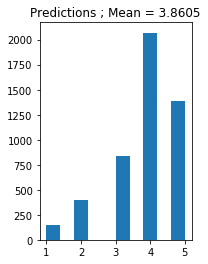

In [469]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))


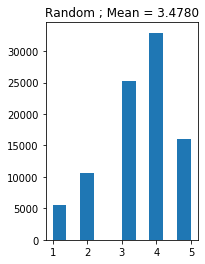

In [470]:
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

In [472]:
ratings, unknown, random_seen = test_actor(actor, movieData.train, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=10)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))



85.2% unknown


Text(0.5, 1.0, 'Predictions ; Mean = 3.8665')

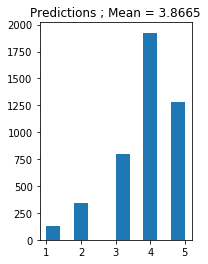

In [475]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))

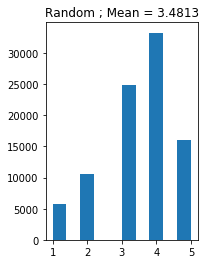

In [474]:
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()